In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv('../../data/train.tsv', sep='\t')
test = pd.read_csv('../../data/test.tsv', sep='\t')
amount = 1000

train.shape

(156060, 4)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

v1 = CountVectorizer(stop_words='english', min_df=2, max_df=0.95, max_features=1000)
X1 = v1.fit_transform(train.Phrase)
print X1.shape

(156060, 1000)


In [12]:
from textblob import TextBlob
def extract_verbs_and_adj(phrase):
    words = []
    
    tags = TextBlob(phrase).tags
    for tag in tags:
        if tag[1][:2] == "VB" or tag[1][:2] == "JJ":
            words.append(tag[0])
    return words

phrases_vb_adj = []
for (index, phrase) in enumerate(train.Phrase[:amount]):
    if index % 10 == 0:
        print index
    phrases_vb_adj.append(' '.join(extract_verbs_and_adj(phrase)))
    
print len(phrases_vb_adj)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


In [13]:
v2 = CountVectorizer(ngram_range=(1, 2),  min_df=2, max_df=0.95, max_features=1000)
X2 = v2.fit_transform(phrases_vb_adj)
print X2.shape

(1000, 229)


In [14]:
sentiments = []
for feature in v2.get_feature_names():
    sentiment = TextBlob(feature).sentiment
    value = sentiment.polarity * sentiment.subjectivity
    sentiments.append(value)
    
print v2.get_feature_names()
print sentiments

[u'absolute', u'aggressive', u'aggressive manipulative', u'aims', u'aims ends', u'amuses', u'amuses much', u'appropriate', u'are', u'are absolute', u'arts', u'arts proves', u'avoid', u'be', u'be damned', u'be martial', u'be mythic', u'becomes', u'becomes offering', u'being', u'big', u'big screen', u'bilingual', u'cliched', u'cliched perverse', u'computer', u'computer generated', u'considerable', u'constructed', u'constructed narrative', u'converted', u'damned', u'defend', u'defend frothing', u'demonstrating', u'demonstrating is', u'different', u'distort', u'distort throw', u'does', u'does give', u'does leave', u'early', u'ends', u'ends sounding', u'entertaining', u'entertaining independent', u'epic', u'exists', u'exists political', u'expect', u'expect more', u'extravagant', u'extravagant distort', u'feel', u'feel other', u'finish', u'first', u'first computer', u'first different', u'followed', u'followed runaway', u'frothing', u'generated', u'generated feel', u'give', u'give be', u'glac

In [15]:
from scipy.sparse import csr_matrix

X3 = csr_matrix(X2.shape)
for index in range(X2.shape[0]):
    row = X2[index]
    for col in range(row.shape[1]):
        X3[index, col] = X2[index, col] * sentiments[col]

In [16]:
from scipy.sparse import hstack
X4 = hstack([X1[:amount], X3])
print X4.shape

(1000, 1229)


trial number: 0
trial number: 1
trial number: 2
trial number: 3
trial number: 4
trial number: 5
trial number: 6
trial number: 7
trial number: 8
trial number: 9
trial number: 10
trial number: 11
trial number: 12
trial number: 13
trial number: 14
trial number: 15
trial number: 16
trial number: 17
trial number: 18
trial number: 19


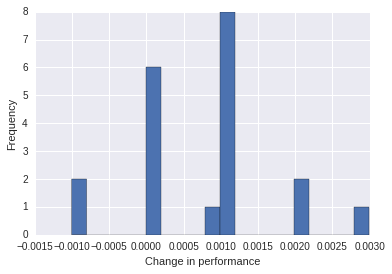

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import sys

def do_trial(X1, X2, y):
    alg = RandomForestClassifier(n_estimators=50, max_depth = 3)
    # change Shuffle to False to see how this affects the conclusions
    cv = cross_validation.StratifiedKFold(y, 3, shuffle=True)
    
    score1 = cross_validation.cross_val_score(alg, X1, y, cv=cv)
    score2 = cross_validation.cross_val_score(alg, X2, y, cv=cv)
    return score1.mean() - score2.mean()

results = []
n_trials = 20
for i in range(n_trials):
    print "trial number: %d" % i
    sys.stdout.flush()
    results.append(do_trial(X3, X4, train.Sentiment[:amount]))
    
plt.hist(results, bins=20)
plt.xlabel('Change in performance')
plt.ylabel('Frequency')
plt.show()